In [16]:
# imports
import numpy as np
import cupy as cp
import time
from scipy import ndimage as ndi_cpu # Para la convolución en CPU
from cupyx.scipy import ndimage as ndi_gpu # Para la convolución en GPU
import matplotlib.pyplot as plt

### Ejercicio 1 - Operaciones vectorizadas y comparación CPU vs GPU

In [24]:
def crear_imagen(N, num_fuentes=10, sigma_frac=0.05, usar_gpu=False, seed=42):
    """
    Crea una imagen NxN con varias fuentes puntuales y una gaussiana extendida.
    Compatible con NumPy y CuPy.
    """
    # Seleccionar módulo (np o cp)
    if usar_gpu:
        import cupy as cp
        xp = cp
    else:
        import numpy as np
        xp = np

    # Crear coordenadas y matriz base
    y, x = xp.indices((N, N))
    img = xp.zeros((N, N), dtype=xp.float32)

    # Generador aleatorio
    if usar_gpu:
        rng = cp.random.RandomState(seed)
        xs = rng.randint(0, N, size=num_fuentes)
        ys = rng.randint(0, N, size=num_fuentes)
        amps = rng.uniform(0.3, 1.0, size=num_fuentes)
    else:
        rng = np.random.default_rng(seed)
        xs = rng.integers(0, N, size=num_fuentes)
        ys = rng.integers(0, N, size=num_fuentes)
        amps = rng.uniform(0.3, 1.0, size=num_fuentes)

    # Fuentes puntuales
    for xi, yi, a in zip(xs, ys, amps):
        img[yi, xi] = a

    # Fuente gaussiana extendida en el centro
    sigma = sigma_frac * N
    gauss = xp.exp(-(((x - N/2)**2 + (y - N/2)**2) / (2 * sigma**2)))
    img += 0.8 * gauss

    return img



def kernel_5x5(xp):
    """Filtro 5x5 normalizado (desenfoque gaussiano)"""
    k = xp.array([[1,4,6,4,1],
                  [4,16,24,16,4],
                  [6,24,36,24,6],
                  [4,16,24,16,4],
                  [1,4,6,4,1]], dtype=xp.float32)
    return k / k.sum()



def convolve(image, device='cpu'):
    """
    Convoluciona la imagen con un kernel 5x5 usando CPU o GPU.
    
    Parámetros
    ----------
    image : np.ndarray o cp.ndarray
        Imagen a convolucionar
    device : str
        'cpu' para usar SciPy (CPU), 'gpu' para usar cupyx (GPU)

    Devuelve
    --------
    result : np.ndarray o cp.ndarray
        Imagen convolucionada
    """
    if device == 'cpu':
        kernel = kernel_5x5(np)
        result = ndi_cpu.convolve(image, kernel, mode='reflect')
    elif device == 'gpu':
        kernel = kernel_5x5(cp)
        result = ndi_gpu.convolve(image, kernel, mode='reflect')
    else:
        raise ValueError("device debe ser 'cpu' o 'gpu'")
    
    return result


def ufunc(image, device='cpu'):
    """
    Aplica la función log1p a la imagen usando CPU o GPU.
    """
    if device == 'cpu':
        img = np.log1p(image + 1)
    else:
        img = cp.log1p(image + 1)
    return img

In [27]:
def medir_tiempo(func, repeticiones=5):
    tiempos = []
    for _ in range(repeticiones):
        t0 = time.perf_counter()
        func()
        t1 = time.perf_counter()
        tiempos.append(t1 - t0)
    return np.mean(tiempos), np.std(tiempos)

def comparar_tiempos(N, fuentes, sigma, seed):
    img_cpu = crear_imagen(N, num_fuentes=fuentes, sigma_frac=sigma, usar_gpu=False, seed=seed)
    img_gpu = crear_imagen(N, num_fuentes=fuentes, sigma_frac=sigma, usar_gpu=True, seed=seed)

    def cpu_conv():
        convolve(img_cpu, device='cpu')
    def cpu_ufunc():
        ufunc(img_cpu, device='cpu')
    def gpu_conv():
        convolve(img_gpu, device='gpu')
        cp.cuda.Device().synchronize()
    def gpu_ufunc():
        ufunc(img_gpu, device='gpu')
        cp.cuda.Device().synchronize()

    cpu_conv_time, cpu_conv_std = medir_tiempo(cpu_conv)
    cpu_ufunc_time, cpu_ufunc_std = medir_tiempo(cpu_ufunc)
    gpu_conv_time, gpu_conv_std = medir_tiempo(gpu_conv)        
    gpu_ufunc_time, gpu_ufunc_std = medir_tiempo(gpu_ufunc) 

    speedup_cpu_conv = cpu_conv_time / gpu_conv_time
    speedup_cpu_ufunc = cpu_ufunc_time / gpu_ufunc_time

    print(f"Tamaño imagen: {N}x{N}, Fuentes: {fuentes}, Sigma_frac: {sigma}")
    print(f"Convolución CPU: {cpu_conv_time:.4f} ± {cpu_conv_std:.4f} s")
    print(f"Convolución GPU: {gpu_conv_time:.4f} ± {gpu_conv_std:.4f} s")
    print(f"Speedup convolución: {speedup_cpu_conv:.2f}x")
    print(f"Ufunc CPU: {cpu_ufunc_time:.4f} ± {cpu_ufunc_std:.4f} s")
    print(f"Ufunc GPU: {gpu_ufunc_time:.4f} ± {gpu_ufunc_std:.4f} s")
    print(f"Speedup ufunc: {speedup_cpu_ufunc:.2f}x")
    print("-" * 60)



In [25]:
image = crear_imagen(1024, num_fuentes=500, sigma_frac=0.05, usar_gpu=True, seed=42)


In [20]:
kernel  = kernel_5x5(cp)

In [21]:
convolved = convolve(image, device='cpu')

In [30]:
comparar_tiempos(N=1024, fuentes=80, sigma=0.05, seed=42)

Tamaño imagen: 1024x1024, Fuentes: 80, Sigma_frac: 0.05
Convolución CPU: 0.0094 ± 0.0005 s
Convolución GPU: 0.0002 ± 0.0002 s
Speedup convolución: 38.50x
Ufunc CPU: 0.0038 ± 0.0002 s
Ufunc GPU: 0.0000 ± 0.0000 s
Speedup ufunc: 87.91x
------------------------------------------------------------


### Ejercicio 2 - FFT 2D e imagen sucia en grilla

N=512: CPU=0.0070s, GPU=0.5392s, Speedup=0.01x
N=1024: CPU=0.0262s, GPU=0.0477s, Speedup=0.55x
N=2048: CPU=0.1129s, GPU=0.0525s, Speedup=2.15x
N=4096: CPU=0.5437s, GPU=0.0199s, Speedup=27.27x


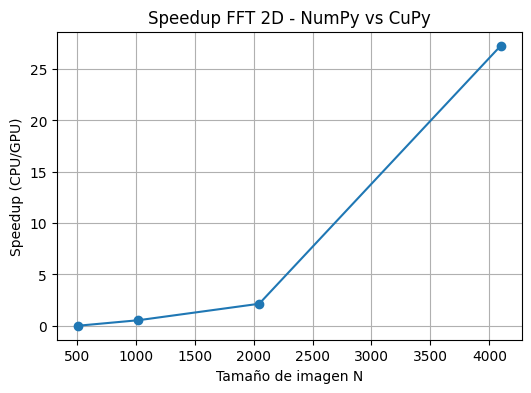

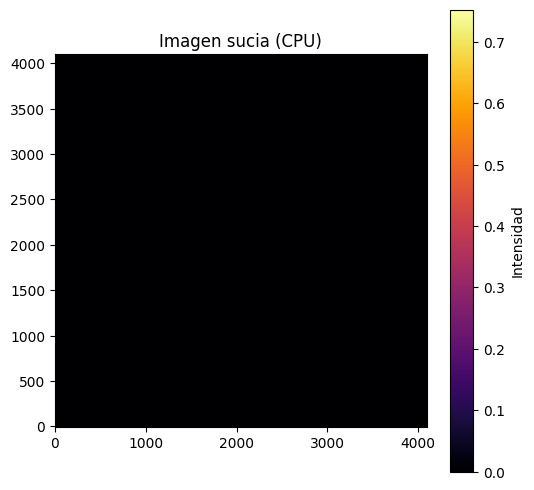

In [31]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from time import time

# ---------- Parámetros ----------
N_list = [512, 1024, 2048, 4096]   # tamaños de grilla
d = 1.0 / N_list[0]                # separación entre muestras (escala arbitraria)

# Posiciones de dos fuentes puntuales en coordenadas de la imagen
src_positions = [(-0.05, 0), (0.05, 0)]  # separadas en dirección l

# Intensidades
src_intensities = [1.0, 0.7]

# ---------- Función para generar visibilidades V(u,v) ----------
def generate_visibilities(N, src_pos, src_I):
    """Genera visibilidades en una malla regular (u,v) para una escena de 2 fuentes."""
    u = np.fft.fftfreq(N, d)
    v = np.fft.fftfreq(N, d)
    uu, vv = np.meshgrid(u, v)
    V = np.zeros_like(uu, dtype=np.complex64)
    for (l, m), I in zip(src_pos, src_I):
        V += I * np.exp(-2j * np.pi * (uu * l + vv * m))
    return V

# ---------- CPU (NumPy) ----------
def dirty_image_cpu(N):
    V = generate_visibilities(N, src_positions, src_intensities)
    t0 = time()
    img = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(V)))
    cp.cuda.runtime.deviceSynchronize()  # no tiene efecto, pero simétrico
    t_cpu = time() - t0
    return np.abs(img), t_cpu

# ---------- GPU (CuPy) ----------
def dirty_image_gpu(N):
    V_cpu = generate_visibilities(N, src_positions, src_intensities)
    V = cp.asarray(V_cpu)
    cp.cuda.runtime.deviceSynchronize()
    t0 = time()
    img = cp.fft.fftshift(cp.fft.ifft2(cp.fft.ifftshift(V)))
    cp.cuda.runtime.deviceSynchronize()
    t_gpu = time() - t0
    return cp.asnumpy(cp.abs(img)), t_gpu

# ---------- Ejecución y comparación ----------
cpu_times, gpu_times = [], []

for N in N_list:
    img_cpu, t_cpu = dirty_image_cpu(N)
    img_gpu, t_gpu = dirty_image_gpu(N)
    cpu_times.append(t_cpu)
    gpu_times.append(t_gpu)
    print(f"N={N}: CPU={t_cpu:.4f}s, GPU={t_gpu:.4f}s, Speedup={t_cpu/t_gpu:.2f}x")

# ---------- Gráfico Speedup ----------
speedup = np.array(cpu_times) / np.array(gpu_times)
plt.figure(figsize=(6,4))
plt.plot(N_list, speedup, marker='o')
plt.xlabel("Tamaño de imagen N")
plt.ylabel("Speedup (CPU/GPU)")
plt.title("Speedup FFT 2D - NumPy vs CuPy")
plt.grid(True)
plt.show()

# ---------- Visualización de la imagen sucia ----------
plt.figure(figsize=(6,6))
plt.imshow(img_cpu, cmap='inferno', origin='lower')
plt.title("Imagen sucia (CPU)")
plt.colorbar(label='Intensidad')
plt.show()
